# SPECT: Using Priors

In [1]:
import os
from pytomography.io.SPECT import simind
from pytomography.priors import RelativeDifferencePrior
from pytomography.projections import SPECTSystemMatrix
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEMBSR
from pytomography.priors import QuadraticPrior, RelativeDifferencePrior
from pytomography.priors import AnatomyNeighbourWeight, TopNAnatomyNeighbourWeight
from torch import poisson
import matplotlib.pyplot as plt

Modify the following path to the directory where you saved the tutorial data:

In [2]:
path = '/disk1/pytomography_tutorial_data/simind_tutorial/'

The first cell of code is borrowed from the `SPECT: Reconstructing SIMIND Data` tutorial in the multiple regions case. For a more description about the code below, please see that tutorial.

In [3]:
organs = ['bkg', 'liver', 'l_lung', 'r_lung', 'l_kidney', 'r_kidney','salivary', 'bladder']
activities = [2500, 450, 7, 7, 100, 100, 20, 90] # MBq
headerfiles = [os.path.join(path, 'multi_projections', organ, 'photopeak.h00') for organ in organs]
headerfiles_lower = [os.path.join(path, 'multi_projections', organ, 'lowerscatter.h00') for organ in organs]
headerfiles_upper = [os.path.join(path, 'multi_projections', organ, 'upperscatter.h00') for organ in organs]
object_meta, image_meta = simind.get_metadata(headerfiles[0]) #assumes the same for all
photopeak = simind.combine_projection_data(headerfiles, activities)
scatter = simind.combine_scatter_data_TEW(headerfiles, headerfiles_lower, headerfiles_upper, activities)
# Convert from CPS to counts
dT = 15 #s
photopeak *= dT
scatter *= dT
photopeak_poisson = poisson(photopeak)
scatter_poisson = poisson(scatter)
# Obtain required transforms to build system matrix
attenuation_map = simind.get_atteuation_map(os.path.join(path, 'multi_projections', 'mu208.hct'))
att_transform = SPECTAttenuationTransform(attenuation_map)
psf_meta = simind.get_psfmeta_from_header(headerfiles[0])
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    im2im_transforms = [],
    object_meta = object_meta,
    image_meta = image_meta,
    n_parallel=8)

Once the system matrix is setup, its time to define the priors for the reconstruction algorithm. PyTomography has many useful prior functions for SPECT reconstruction. Most of them are derived from `NearestNeighbourPrior`; meaning prior information for each voxel only depends on the neighbouring 26 voxels. Priors can be defined as follows:

In [4]:
prior_quad = QuadraticPrior(beta=0.3)
prior_rdp = RelativeDifferencePrior(beta=0.3, gamma=2)

By default, the "contribution" (or *weight*) from the 26 neighbouring voxels is scaled by the Euclidean distance from the central voxel. Voxels on the corners (8 total) therefore only contribute $1/\sqrt{3}$ compared to the adjacent 6 (up/down, left/right, front/back). The weight in this case is an instance of `EuclideanNeighbourWeight`.

PyTomography also has options to use other weights for neighbouring voxels. For example, it can use anatomical images (such as attenuation maps and CT images) to obtain a different weighting scheme. For example, the `TopNAnatomyNeighbourWeight` is an extension of `EuclideanNeighbourWeight` that only uses non-zero weights for the top-N closest neighbours based on an external anatomical image:

In [5]:
weight_top8anatomy = TopNAnatomyNeighbourWeight(attenuation_map, N_neighbours=8)

This can be used to create custom priors with the given weighing. These are typically referred to as anatomical priors (AP) and would be designated as Quadratic-AP or RDP-AP

In [6]:
prior_quad_weighttop8 = QuadraticPrior(beta=0.3, weight=weight_top8anatomy)
prior_rdp_weighttop8 = RelativeDifferencePrior(beta=0.3, gamma=2, weight=weight_top8anatomy)

We can now reconstruct this object using no prior, and the four prior functions we just defined

In [7]:
def reconstruct(prior):
    reconstruction_algorithm = OSEMBSR(
    image = photopeak_poisson,
    system_matrix = system_matrix,
    scatter = scatter_poisson,
    prior=prior)
    return reconstruction_algorithm(n_iters=40, n_subsets=8)

Note: The following cell may take a while to run depending on your system/graphics card.

In [8]:
recon_noprior = reconstruct(None)
recon_quad = reconstruct(prior_quad)
recon_rdp = reconstruct(prior_rdp)
recon_quad_weighttop8 = reconstruct(prior_quad_weighttop8)
recon_rdp_weighttop8 = reconstruct(prior_rdp_weighttop8)

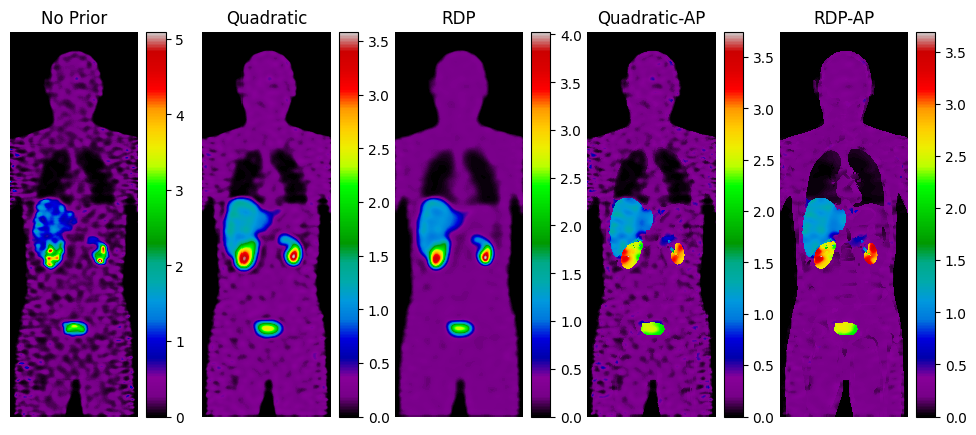

In [9]:
plt.subplots(1,5,figsize=(12,5))
plt.subplot(151)
plt.pcolormesh(recon_noprior[0].cpu()[:,70].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.title('No Prior')
plt.subplot(152)
plt.pcolormesh(recon_quad[0].cpu()[:,70].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.title('Quadratic')
plt.subplot(153)
plt.pcolormesh(recon_rdp[0].cpu()[:,70].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.title('RDP')
plt.subplot(154)
plt.pcolormesh(recon_quad_weighttop8[0].cpu()[:,70].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.title('Quadratic-AP')
plt.subplot(155)
plt.pcolormesh(recon_rdp_weighttop8[0].cpu()[:,70].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.title('RDP-AP')
plt.show()